# 0. Preparando o ambiente

In [1]:
# Apontando para pasta geral do projeto
import os,sys
FOLDER = sys.path[0][:-20]

# Importando libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

## Descritivo de análises realizadas

* Diferença de movimentação entre os meses
* Número médio de viagens por estações
* Comparativo de uso de bikes por tipos de usuários (assinantes e casuais)
* Métricas de uso com base no tipo de bicicleta (clássica e elétrica)
* Diferenças de uso das bicicletas entre os dias úteis e finais de semana
* Relação entre distância percorrida e duração da viagem
* Demanda por bicicletas ou vagas nas estações

# 1. Importando dados

In [2]:
def import_tripdatabase():
    files_path = [f'{FOLDER}/base_de_dados/{path}' for path in os.listdir(f'{FOLDER}/base_de_dados') if '.parquet' in path]
    tripdatabase = pd.DataFrame()
    
    for file in files_path:
        tripdatabase_ = pd.read_parquet(file)
        tripdatabase = pd.concat([tripdatabase,tripdatabase_],ignore_index=True)

    # Ajustando dados vazios
    tripdatabase[['start_station_name','end_station_name']] = tripdatabase[['start_station_name','end_station_name']].fillna('-')
    # Ajustando colunas que não são string
    tripdatabase[['start_station_id','end_station_id']] = tripdatabase[['start_station_id','end_station_id']].fillna(-1).astype(int)
    tripdatabase[['start_lat','start_lng','end_lat','end_lng']] = tripdatabase[['start_lat','start_lng','end_lat','end_lng']].fillna(-1).astype(float)
    tripdatabase[['rideable_type','member_casual']] = tripdatabase[['rideable_type','member_casual']].astype('category')
    tripdatabase[['started_at','ended_at']] = tripdatabase[['started_at','ended_at']].astype(np.datetime64)
    
    # Renomeando colunas (passando para caixa alta)
    cols_dict = {col:col.upper() for col in tripdatabase.columns}
    tripdatabase = tripdatabase.rename(cols_dict,axis=1)
    
    return tripdatabase

In [3]:
tripdatabase = import_tripdatabase()

## Visão geral

In [4]:
print(tripdatabase.dtypes)
tripdatabase.head()

RIDE_ID                       object
RIDEABLE_TYPE               category
STARTED_AT            datetime64[ns]
ENDED_AT              datetime64[ns]
START_STATION_NAME            object
START_STATION_ID               int32
END_STATION_NAME              object
END_STATION_ID                 int32
START_LAT                    float64
START_LNG                    float64
END_LAT                      float64
END_LNG                      float64
MEMBER_CASUAL               category
dtype: object


,RIDE_ID,RIDEABLE_TYPE,STARTED_AT,ENDED_AT,START_STATION_NAME,START_STATION_ID,END_STATION_NAME,END_STATION_ID,START_LAT,START_LNG,END_LAT,END_LNG,MEMBER_CASUAL
0,DD15685B4DF313D3,classic_bike,2022-03-15 18:00:08,2022-03-15 18:17:02,Convention Center / 7th & M St NW,31223,4th St & G St SW,31666,38.905737,-77.022270,38.881123,-77.017658,member
1,0E4FE31A025C2769,classic_bike,2022-03-20 18:19:43,2022-03-20 18:25:28,1st & D St SE,31643,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613,38.884916,-77.005965,38.884095,-76.995234,member
2,BC0E187D127FB5BB,classic_bike,2022-03-16 12:44:09,2022-03-16 12:48:00,6th & H St NE,31615,1st & K St NE,31662,38.899972,-76.998347,38.902386,-77.005649,member
3,468D0F03E6B55135,electric_bike,2022-03-15 14:12:54,2022-03-15 14:17:44,N Lynn St & Fairfax Dr,31917,Wilson Blvd & N Oak St,31939,38.893740,-77.070881,38.895068,-77.073860,member
4,1785DDDC5AF69E4D,classic_bike,2022-03-18 16:34:18,2022-03-18 17:27:02,16th & Irving St NW,31122,Eastern Market / 7th & North Carolina Ave SE,31610,38.928893,-77.036250,38.886952,-76.996806,member


# 2. Colunas auxiliares

In [5]:
# Mês da viagem
tripdatabase['NO_AM'] = tripdatabase.STARTED_AT.dt.strftime('%Y%m')

# Duração em dias, horas e minutos
tripdatabase['DURATION_D'] = (tripdatabase.ENDED_AT - tripdatabase.STARTED_AT)/np.timedelta64(1,'D')
tripdatabase['DURATION_H'] = (tripdatabase.ENDED_AT - tripdatabase.STARTED_AT)/np.timedelta64(1,'h')
tripdatabase['DURATION_MIN'] = (tripdatabase.ENDED_AT - tripdatabase.STARTED_AT)/np.timedelta64(1,'m')

# Distância das viagens
tripdatabase['DISTANCE'] = tripdatabase.apply(lambda df: distance((df.START_LAT,df.START_LNG),(df.END_LAT,df.END_LNG)).km if df.END_LAT != -1 else float('nan'),axis=1)
# DISTANCE demora em torno de 18 min para rodar! opte por salvar uma base agregada para acesso rápido após primeira leitura/processamento

In [3]:
# Salvando dados para evitar repetir processamentos demorados
# tripdatabase.to_parquet(f'{FOLDER[:-24]}/agregada/capitalbikeshare-tripdata-agg.parquet')

# 3. Análise exploratória

In [4]:
sns.set_style('darkgrid')
sns.set_context('paper')

## 3.1. Tipos de bicicleta

### Utilização de bicicletas geral

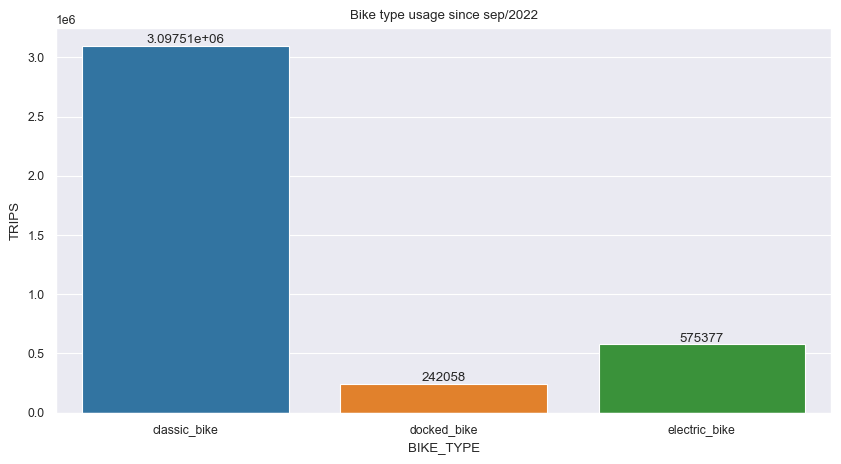

In [5]:
df_bike = (
    tripdatabase
    .groupby('RIDEABLE_TYPE',as_index=False)
    .agg(TRIPS = ('RIDE_ID','count'))
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE'},axis=1)
)
plt.figure(figsize=(10,5))
graph = sns.barplot(df_bike,x='BIKE_TYPE',y='TRIPS')
graph.bar_label(graph.containers[0])
plt.title('Bike type usage since sep/2022')
plt.show()

- Predominância do tipo clássico

- Embora o tipo clássico seja o mais utilizado de forma geral, será que isso é verdade ao longo dos meses?

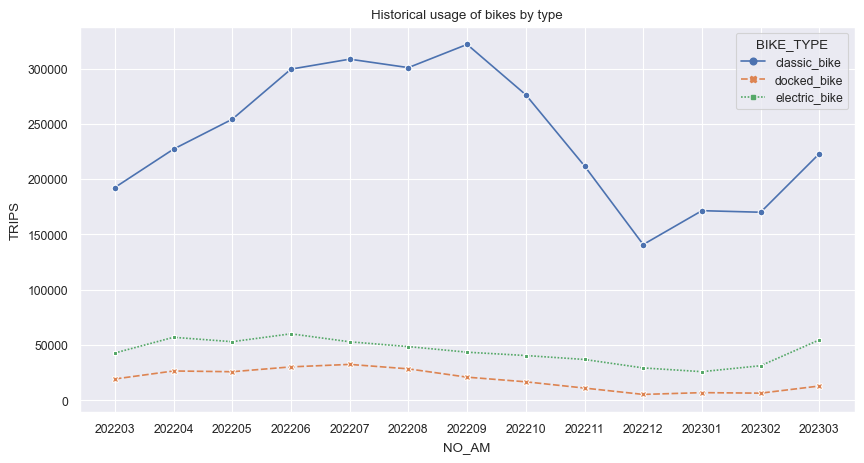

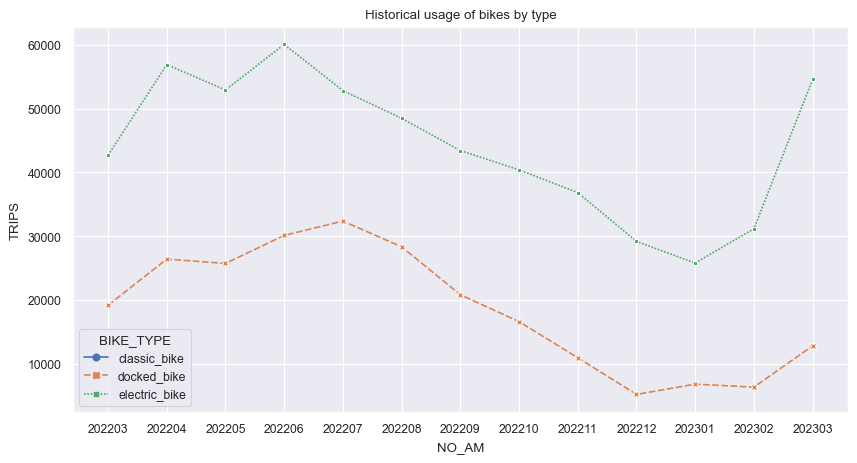

In [219]:
df_bike = (
    tripdatabase
    .groupby(['NO_AM','RIDEABLE_TYPE'],as_index=False)
    .agg(TRIPS = ('RIDE_ID','count'))
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE'},axis=1)
)
# Todos os tipos
plt.figure(figsize=(10,5))
sns.lineplot(df_bike,x='NO_AM',y='TRIPS',hue='BIKE_TYPE',style='BIKE_TYPE',markers=True)
plt.title('Historical usage of bikes by type')
plt.show()

# Sem o tipo clássico
plt.figure(figsize=(10,5))
graph = sns.lineplot(df_bike[df_bike.BIKE_TYPE != 'classic_bike'],x='NO_AM',y='TRIPS',
             hue='BIKE_TYPE',style='BIKE_TYPE',markers=True)
plt.title('Historical usage of bikes by type')
plt.show()

- O uso de bicicletas clássicas é predominantes em todos os meses
- É possível observar quedas no uso das bicicletas de modo geral, com leve retomada de crescimento a partir de dez/2022
- Vale ressaltar que enquanto a utilização de bicicletas elétricas diminuiu de dez/22 a jan/23, as demais começam a ter um leve aumento no número de utilizações. 
- A utilização de bicicletas elétricas demonstra tendência de crescimento muito maior do que as demais a partir de jan/23 

### Tipos de bicicletas mais utilizadas por cada tipo de membro

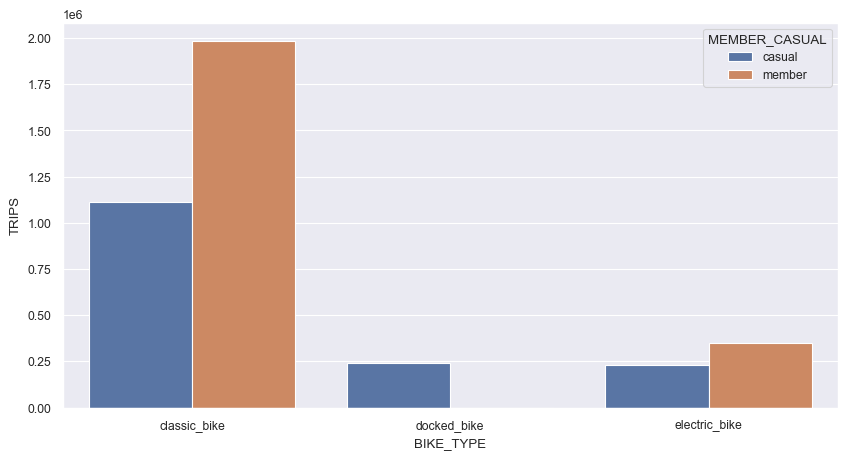

In [230]:

df_bike_member = (
    tripdatabase
    .groupby(['RIDEABLE_TYPE','MEMBER_CASUAL'],as_index=False)['RIDE_ID']
    .count()
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE','RIDE_ID':'TRIPS'},axis=1)
)
plt.figure(figsize=(10,5))
sns.barplot(df_bike_member,x='BIKE_TYPE',y='TRIPS',hue='MEMBER_CASUAL');
plt.show()

É possível retirar duas informações relevantes a partir deste gráfico:
1. A "docked_bike" é, provavelmente, como são classificadas as bikes clássicas usadas por consumidores casuais com passe de 24h. 
    - Uma fonte explicando como a capital bikeshare define esse dado não foi encontrada, portanto, essa informação ainda é 
2. A quantidade de viagens realizadas por membros supera as viagens casuais em qualquer categoria

### Visão temporal

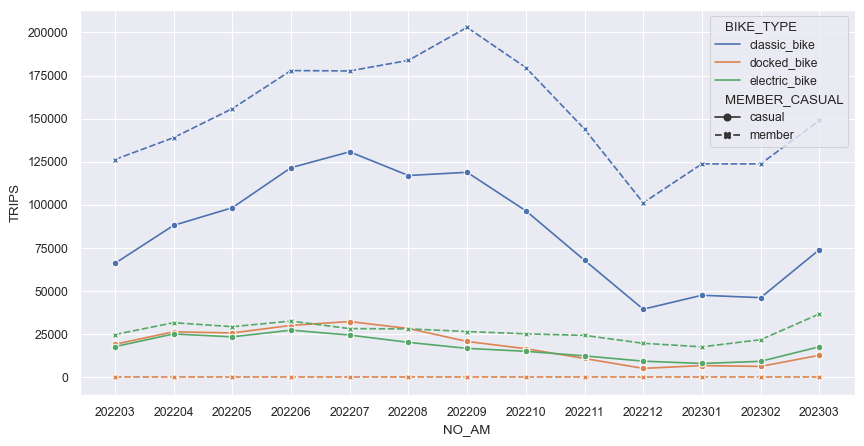

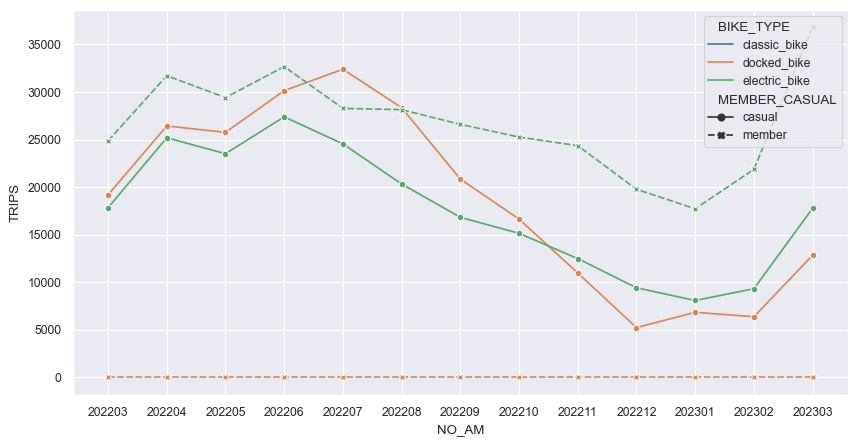

In [235]:
df_bike_member = (
    tripdatabase
    .groupby(['NO_AM','RIDEABLE_TYPE','MEMBER_CASUAL'],as_index=False)['RIDE_ID']
    .count()
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE','RIDE_ID':'TRIPS'},axis=1)
)
plt.figure(figsize=(10,5))
sns.lineplot(df_bike_member,x='NO_AM',y='TRIPS',hue='BIKE_TYPE',style='MEMBER_CASUAL',markers=True)
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(df_bike_member[df_bike_member.BIKE_TYPE != 'classic_bike'],x='NO_AM',y='TRIPS',hue='BIKE_TYPE',style='MEMBER_CASUAL',markers=True)
plt.show()

- A tendência de aumento ou diminuição no número de viagens por tipo de membro é similar para a clássica e elétrica
- Apenas o tipo "docked" difere dos demais, sofrendo queda de uso de forma retardada, perdendo espaço para uso de bicicletas eletrícas após out/2022

## 3.2. Estações

In [239]:
# Criando dimensão para saber o nome das estações.
# Sabendo que o nome das estações muda ao longo do tempo, o nome mais recente para cada ID será coletado
dm_estacao = pd.concat([
    tripdatabase.rename({'START_STATION_ID':'STATION_ID','START_STATION_NAME':'STATION_NAME'},axis=1)[['STATION_ID','STATION_NAME','NO_AM']],
    tripdatabase.rename({'END_STATION_ID':'STATION_ID','END_STATION_NAME':'STATION_NAME'},axis=1)[['STATION_ID','STATION_NAME','NO_AM']]
])
dm_estacao = (
    dm_estacao
    .sort_values('NO_AM',ascending=False)
    .groupby('STATION_ID',as_index=False)['STATION_NAME']
    .first()
)

### Top estações mais utilizadas - Início da viagem

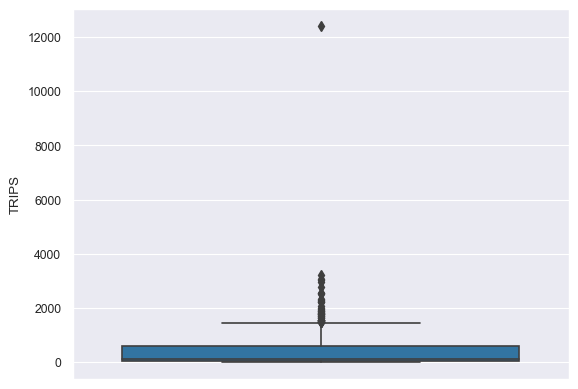

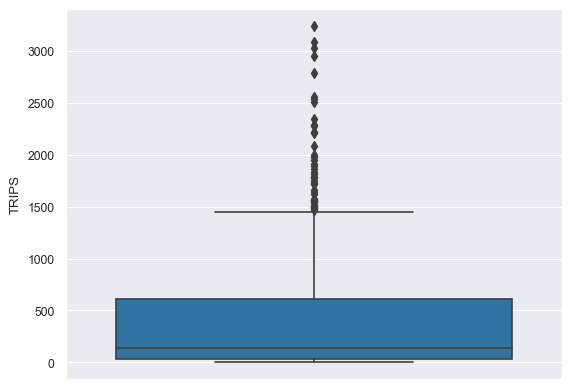

Existem 181 estações acima do percentil 75, representando 71.20% do total de viagens


In [23]:
# Média mensal de viagens por estação ao longo do ano
df_estacao_inicio = (
    tripdatabase
    .groupby(['NO_AM','START_STATION_ID'],as_index=False)
    .agg(STATION_NAME = ('START_STATION_NAME','first'),TRIPS = ('RIDE_ID','count'))
    .sort_values('NO_AM',ascending=False)
    .groupby('START_STATION_ID',as_index=False)
    .agg(STATION_NAME = ('STATION_NAME','first'),TRIPS = ('TRIPS','mean'))
    .sort_values('TRIPS',ascending=False)
)

sns.boxplot(df_estacao_inicio,y='TRIPS')
plt.show()

# Viagens sem ponto específico de partida dizem a respeito de bicicletas elétricas estacionadas foras das estações
# Tais registros são removidos pois fogem doe escopo da análise
sns.boxplot(df_estacao_inicio[df_estacao_inicio.START_STATION_ID != -1],y='TRIPS')
plt.show()

# Muitos locais se destacam, contudo, não necessariamente são outliers, mas sim regiões com alto fluxo de pessoas
p75 = df_estacao_inicio.TRIPS.quantile(.75)
estacoes_acima_p75 = df_estacao_inicio[(df_estacao_inicio.TRIPS > p75) & (df_estacao_inicio.START_STATION_ID != -1)].START_STATION_ID.nunique()
pc_viagens_acima_p75 = df_estacao_inicio[(df_estacao_inicio.TRIPS > p75) & (df_estacao_inicio.START_STATION_ID != -1)].TRIPS.sum()/df_estacao_inicio.TRIPS.sum()
print(f'Existem {estacoes_acima_p75} estações acima do percentil 75, representando {pc_viagens_acima_p75*100:.2f}% do total de viagens')

- 72% das viagens são provenientes de 25% das estações, seguindo de certa forma o princípio de pareto (80% das viagens ocorreriam em 20% das estações)

In [24]:
# TOP 10 mais utilizadas
top10_start = df_estacao_inicio[df_estacao_inicio.START_STATION_ID != -1].sort_values('TRIPS',ascending=False).head(10)
top10_start

,START_STATION_ID,STATION_NAME,TRIPS
362,31623,Columbus Circle / Union Station,3235.923077
168,31229,New Hampshire Ave & T St NW,3081.384615
197,31258,Lincoln Memorial,3024.615385
140,31201,15th & P St NW,2950.153846
186,31247,Jefferson Dr & 14th St SW,2782.692308
187,31248,Smithsonian-National Mall / Jefferson Dr & 12t...,2559.000000
343,31603,1st & M St NE,2538.153846
227,31288,4th St & Madison Dr NW,2509.461538
340,31600,5th & K St NW,2345.923077
228,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,2286.769231


### Top estações mais utilizadas - Fim da viagem

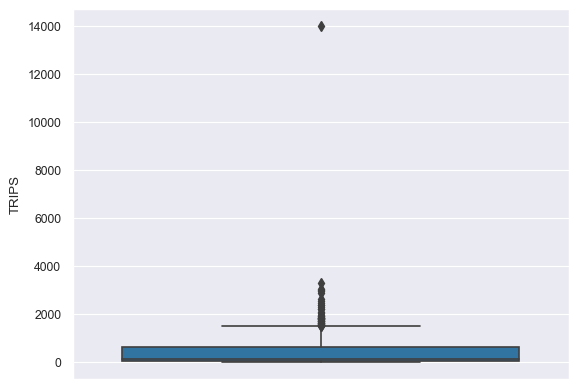

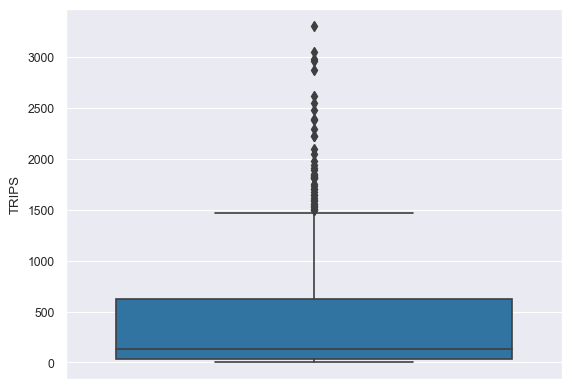

Existem 181 estações acima do percentil 75, representando 71.78% do total de viagens


In [25]:
# Média mensal de viagens por estação ao longo do ano
df_estacao_fim = (
    tripdatabase
    .groupby(['NO_AM','END_STATION_ID'],as_index=False)
    .agg(STATION_NAME = ('END_STATION_NAME','first'),TRIPS = ('RIDE_ID','count'))
    .sort_values('NO_AM',ascending=False)
    .groupby('END_STATION_ID',as_index=False)
    .agg(STATION_NAME = ('STATION_NAME','first'),TRIPS = ('TRIPS','mean'))
    .sort_values('TRIPS',ascending=False)
)

sns.boxplot(df_estacao_fim,y='TRIPS')
plt.show()

# Viagens sem ponto específico de partida dizem a respeito de bicicletas elétricas estacionadas foras das estações
# Tais registros são removidos pois fogem doe escopo da análise
sns.boxplot(df_estacao_fim[df_estacao_fim.END_STATION_ID != -1],y='TRIPS')
plt.show()

# Muitos locais se destacam, contudo, não necessariamente são outliers, mas sim regiões com alto fluxo de pessoas
p75 = df_estacao_fim.TRIPS.quantile(.75)
estacoes_acima_p75 = df_estacao_fim[(df_estacao_fim.TRIPS > p75) & (df_estacao_fim.END_STATION_ID != -1)].END_STATION_ID.nunique()
pc_viagens_acima_p75 = df_estacao_fim[(df_estacao_fim.TRIPS > p75) & (df_estacao_fim.END_STATION_ID != -1)].TRIPS.sum()/df_estacao_fim.TRIPS.sum()
print(f'Existem {estacoes_acima_p75} estações acima do percentil 75, representando {pc_viagens_acima_p75*100:.2f}% do total de viagens')
# 73% das viagens são provenientes de 25% das estações, também seguindo de certa forma o princípio de pareto

In [26]:
# TOP 10 mais utilizadas
top10_end = df_estacao_fim[df_estacao_fim.END_STATION_ID != -1].sort_values('TRIPS',ascending=False).head(10)
top10_end

,END_STATION_ID,STATION_NAME,TRIPS
362,31623,Columbus Circle / Union Station,3306.000000
168,31229,New Hampshire Ave & T St NW,3055.384615
197,31258,Lincoln Memorial,2987.000000
140,31201,15th & P St NW,2966.000000
186,31247,Jefferson Dr & 14th St SW,2876.153846
187,31248,Smithsonian-National Mall / Jefferson Dr & 12t...,2622.000000
343,31603,1st & M St NE,2553.615385
227,31288,4th St & Madison Dr NW,2486.461538
139,31200,Massachusetts Ave & Dupont Circle NW,2389.615385
340,31600,5th & K St NW,2381.230769


# 3.3. Uso em dias de semana e finais de semana

In [54]:
tripdatabase['WEEKDAY'] = tripdatabase['STARTED_AT'].dt.day_of_week
tripdatabase['WEEKEND'] = np.where(tripdatabase['WEEKDAY'].isin([5,6]),1,0)
tripdatabase['WEEKDAY_TYPE'] = np.where(tripdatabase['WEEKDAY'] == 5,'saturday',
                                        np.where(tripdatabase['WEEKDAY'] == 6, 'sunday','business_day'))

### Soma mensal de viagens em dias úteis e finais de semana

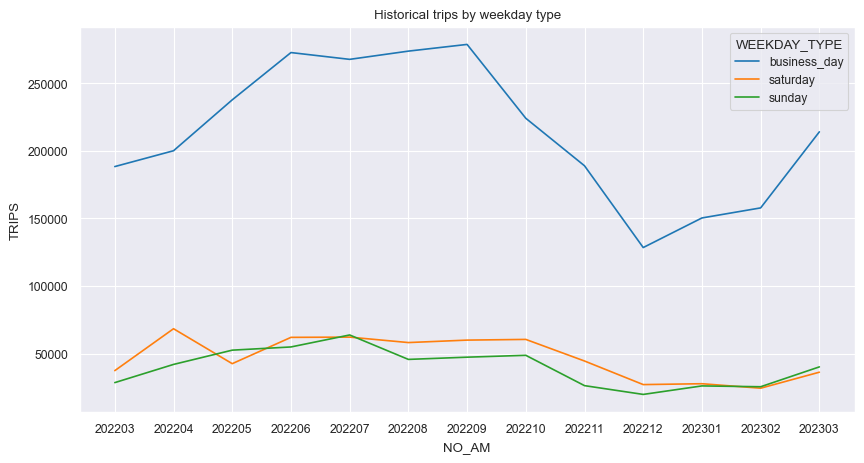

In [64]:
df_viagem_dia = (
    tripdatabase
    .groupby(['NO_AM','WEEKDAY_TYPE'],as_index=False)
    .agg(TRIPS=('RIDE_ID','count'))
    # .groupby('WEEKDAY_TYPE',as_index=False)['TRIPS']
    # .mean()
)
plt.figure(figsize=(10,5))
sns.lineplot(df_viagem_dia,x='NO_AM',y='TRIPS',hue='WEEKDAY_TYPE')
plt.title('Historical trips by weekday type')
plt.show()

- Há muito mais viagens em dias úteis, indicando forte indício de uso para deslocamentos daiários para trabalho ou faculdade, por exemplo
- Interessante observar a queda que ocorre em dezembro, provavelmente reflexo de períodos de festas e férias coletivas

### Uso de bike em dias úteis e finais de semana por tipo de usuário

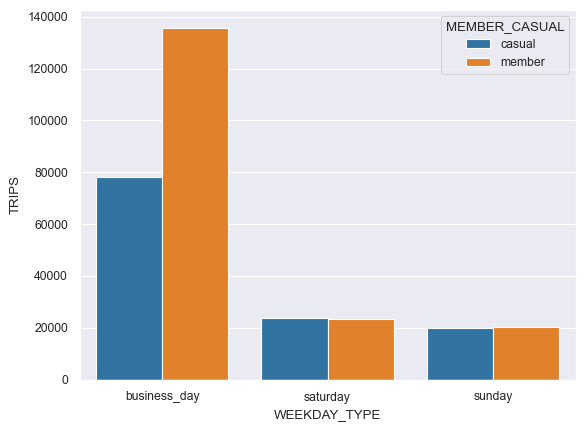

In [83]:
df_viagem_dia_membro = (
    tripdatabase
    .groupby(['NO_AM','WEEKDAY_TYPE','MEMBER_CASUAL'],as_index=False)
    .agg(TRIPS=('RIDE_ID','count'))
    .groupby(['MEMBER_CASUAL','WEEKDAY_TYPE'],as_index=False)['TRIPS']
    .mean()
)
sns.barplot(df_viagem_dia_membro,x='WEEKDAY_TYPE',y='TRIPS',hue='MEMBER_CASUAL');


- Pessoas que pagam assinatura realizam mais viagens em dias de semanas, justificando o motivo delas possuírem assinatura do serviço
- Não há diferença significativa entre o uso de bicicleta por tipo de membro nos finais de semana

# 3.4. Duração e distância de viagens

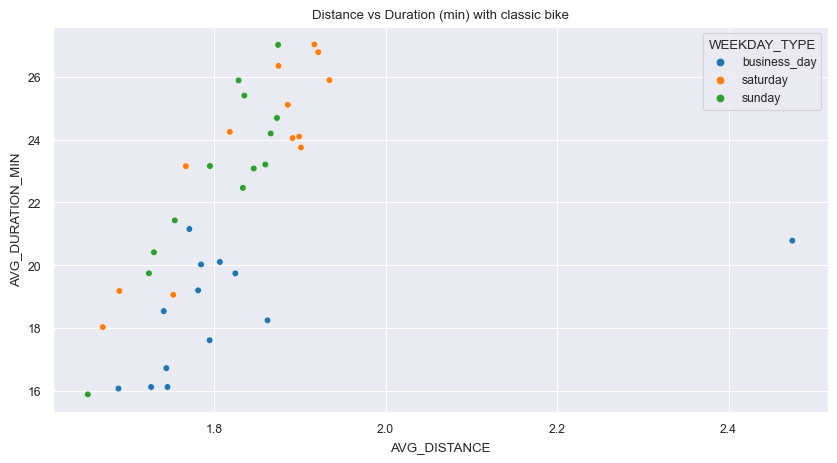

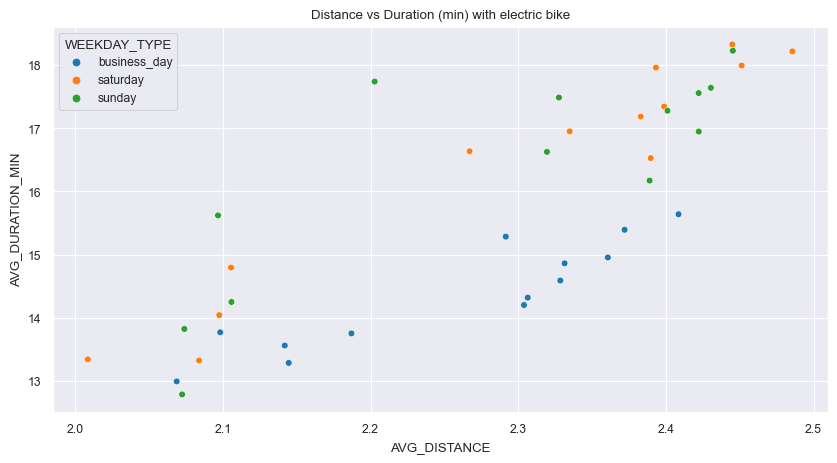

In [92]:
df_duracao_viagem = (
    tripdatabase
    .groupby(['NO_AM','RIDEABLE_TYPE','WEEKDAY_TYPE'],as_index=False)
    .agg(AVG_DURATION_MIN = ('DURATION_MIN','mean'),AVG_DISTANCE = ('DISTANCE','mean'))
)
plt.figure(figsize=(10,5))
sns.scatterplot(df_duracao_viagem[df_duracao_viagem['RIDEABLE_TYPE'] == 'classic_bike'],x='AVG_DISTANCE',y='AVG_DURATION_MIN',hue='WEEKDAY_TYPE')
plt.title('Distance vs Duration (min) with classic bike')
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(df_duracao_viagem[df_duracao_viagem['RIDEABLE_TYPE'] == 'electric_bike'],x='AVG_DISTANCE',y='AVG_DURATION_MIN',hue='WEEKDAY_TYPE')
plt.title('Distance vs Duration (min) with electric bike')
plt.show()

- A duração da viagem é diretamente proporcional à distância percorrida
- Viagens com maior distância e duração tendem a ser realizadas em finais de semana, provavelmente para recreação
- A distância média percorrida nos finais de semana com bicicletas elétricas é maior do que com bicicletas clássicas
- Em contrapartida, a duração média das viagens nos finais de semana é maior na utilização de bicicletas clássicas (por estarem em momentos de recreação, não há necessidade de peladar rápido)

## 3.5 Demanda de Bikes/Vagas

In [111]:
df_demanda = df_estacao_inicio.merge(df_estacao_fim,left_on='START_STATION_ID',right_on='END_STATION_ID',suffixes=('_START','_END'))
df_demanda = df_demanda[df_demanda['START_STATION_ID'] != -1]

# Criando coluna de razão entre demanda de bike e vagas
df_demanda['DB/DV'] = df_demanda['TRIPS_START']/df_demanda['TRIPS_END']

- Quanto menor a razão DB/DV, menor a necessidade de bicicletas no local, e, maior a necessidade de vagas
- DB/DV = 1 significa que a estação é retroalimentada, logo, não há necessidade de atenção para ela

In [113]:
# A análise será focada em estações com média de viagens maior ou igual a 100
df_demanda = df_demanda[(df_demanda['TRIPS_START'] >= 100)]
df_demanda['DEMAND'] = np.where(df_demanda['DB/DV'] > 1.2,'bikes',
                                np.where(df_demanda['DB/DV'] < 0.8,'dockers','stable'))

cols_dict = {'START_STATION_ID':'STATION_ID','START_STATION_NAME':'STATION_NAME'}
df_demanda = df_demanda.rename(cols_dict,axis=1).drop(['END_STATION_ID','STATION_NAME_END'],axis=1)

In [115]:
# Top 10 estações com alta demanda por bike
top10_demanda_bike = df_demanda.sort_values('DB/DV').tail(10)
top10_demanda_dock = df_demanda.sort_values('DB/DV').head(10)

In [116]:
top10_demanda_bike

,STATION_ID,STATION_NAME_START,TRIPS_START,TRIPS_END,DB/DV,DEMAND
220,31105,14th & Harvard St NW,462.307692,281.461538,1.642525,bikes
407,31317,Wisconsin Ave & Ingomar St NW,105.153846,64.000000,1.643029,bikes
60,31102,11th & Kenyon St NW,1277.230769,765.076923,1.669415,bikes
136,31115,Columbia Rd & Georgia Ave NW,828.769231,496.076923,1.670647,bikes
284,31137,Park Pl & Rock Creek Church Rd NW,262.285714,153.428571,1.709497,bikes
76,31602,Park Rd & Holmead Pl NW,1166.384615,673.307692,1.732320,bikes
256,31421,Grant Circle,310.615385,177.461538,1.750325,bikes
215,31106,Calvert & Biltmore St NW,481.153846,247.307692,1.945568,bikes
282,31333,Wisconsin Ave & Rodman St NW,274.625000,114.625000,2.395856,bikes
383,31316,Yuma St & Tenley Circle NW,124.076923,49.538462,2.504658,bikes


In [117]:
top10_demanda_dock

,STATION_ID,STATION_NAME_START,TRIPS_START,TRIPS_END,DB/DV,DEMAND
188,31293,Thomas Jefferson St NW & Water/K St NW,584.000000,887.538462,0.658000,dockers
228,31669,3rd & M St SE,423.692308,606.692308,0.698364,dockers
241,31674,Maine Ave & Water St SW,369.000000,518.000000,0.712355,dockers
133,31225,C & O Canal & Wisconsin Ave NW,832.307692,1156.538462,0.719654,dockers
310,31015,Wilson Blvd & Ft Myer Dr,206.230769,282.692308,0.729524,dockers
202,30200,9th St & Pennsylvania Ave NW,521.500000,710.500000,0.733990,dockers
290,31041,Prince St & Union St,245.461538,325.000000,0.755266,dockers
152,31274,10th & G St NW,747.846154,983.307692,0.760541,dockers
200,31014,19th St N & Ft Myer Dr,527.384615,691.230769,0.762965,dockers
207,31262,11th & F St NW,517.000000,675.230769,0.765664,dockers
